In [1]:
import copy
import numpy as np
import pandas as pd
import scipy.stats
import dftools
import matplotlib.pyplot as plt

Welcome to JupyROOT 6.18/00


In [2]:
plt.style.use("cms")

In [3]:
_df_data = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "Data")
_df_mc = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MC")
_df_mc_smooth = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCSmooth")
_df_mc_p4 = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCPoly4")
_df_mc_flat = pd.read_hdf("data/fitinputs/fixsmoothing.h5", "MCFlat")

_df_data = _df_data.loc[~_df_data.index.duplicated(keep="first")]
_df_mc = _df_mc.loc[~_df_mc.index.duplicated(keep="first")]
_df_mc_smooth = _df_mc_smooth.loc[~_df_mc_smooth.index.duplicated(keep="first")]
_df_mc_p4 = _df_mc_p4.loc[~_df_mc_p4.index.duplicated(keep="first")]
_df_mc_flat = _df_mc_flat.loc[~_df_mc_flat.index.duplicated(keep="first")]

## Modify dataframes

Alter the dataframes, for example, to make or break correlations between systematic uncertainties, remove variations from particular sources, or switch to polyfit smoothing or a flat systematic

### Rename nuisances

In [4]:
region_mapping = {
    "Monojet": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "MonojetQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleTau": {
        "metTrigMuonMultiplicitySyst": "metTrig0MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonMinus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonPlus": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "SingleMuonQCD": {
        "metTrigMuonMultiplicitySyst": "metTrig1MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
    "DoubleMuon": {
        "metTrigMuonMultiplicitySyst": "metTrig2MuSyst",
        "metTrigRegionSyst": "metTrig{region}Syst",
    },
}

for region, mapping in region_mapping.items():
    selection = (_df_mc.index.get_level_values("variation")=="") & (_df_mc.index.get_level_values("region")==region)
    tdf = _df_mc.loc[selection,:]
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Up")) & (_df_mc.index.get_level_values("region")==region)
    tdf_up = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Up": v.format(region=region)+"Up" for k, v in mapping.items()},
    )
    
    selection = (_df_mc.index.get_level_values("variation").str.endswith("Down")) & (_df_mc.index.get_level_values("region")==region)
    tdf_do = _df_mc.loc[selection,:].rename(
        level="variation",
        index={k+"Down": v.format(region=region)+"Down" for k, v in mapping.items()},
    )
    _df_mc = pd.concat([tdf, tdf_up, tdf_do, _df_mc.loc[_df_mc.index.get_level_values("region")!=region,:].copy()], axis=0, sort=False)

## Remove nuisances

In [5]:
_df_mc.loc[("SingleElectron", "WJetsToLNu"),:].index.get_level_values("variation").unique()

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


Index(['', 'alphasDown', 'alphasUp', 'btagSFDown', 'btagSFUp', 'd1kewDown',
       'd1kewUp', 'd1kqcdDown', 'd1kqcdUp', 'd2kewwDown', 'd2kewwUp',
       'd2kewzDown', 'd2kewzUp', 'd2kqcdDown', 'd2kqcdUp', 'd3kewwDown',
       'd3kewwUp', 'd3kewzDown', 'd3kewzUp', 'd3kqcdDown', 'd3kqcdUp',
       'dkmixDown', 'dkmixUp', 'eleEnergyScaleDown', 'eleEnergyScaleUp',
       'eleIdIsoTightDown', 'eleIdIsoTightUp', 'eleIdIsoVetoDown',
       'eleIdIsoVetoUp', 'eleRecoDown', 'eleRecoUp', 'eleTrigDown',
       'eleTrigUp', 'jerSFDown', 'jerSFUp', 'jesTotalDown', 'jesTotalUp',
       'lhePdfWeightDown', 'lhePdfWeightUp', 'lheScaleWeightDown',
       'lheScaleWeightUp', 'lumiDown', 'lumiUp',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigReferenceTriggerSystDown', 'metTrigReferenceTriggerSystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp', 'muonIdLooseStatDown',
       'muonIdLooseStatUp', 'muonIdLooseSystDown', 'muonIdLooseSystUp',
       'muon

In [6]:
region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): [
        "lheScaleWeight", "eleTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleElectron", "WJetsToLNu"): [
        "lheScaleWeight", "muonTrig",
        #"d1kqcd", "d2kqcd", "d3kqcd", "dkmix",
        #"d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz",
        #"lumi",
    ],
    ("SingleMuon", "QCD"): ["eleTrig"],
    ("SingleMuon", "MinorBkgs"): ["eleTrig"],
    ("SingleElectron", "MinorBkgs"): ["muonTrig"],
}

drops = [
    (r, p, v+"Up")
    for (r, p), vs in region_process_variations.items()
    for v in vs
] + [
    (r, p, v+"Down")
    for (r, p), vs in region_process_variations.items()
    for v in vs
]
_df_mc = _df_mc.drop(drops, errors='ignore')

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: PerformanceWarning: indexing past lexsort depth may impact performance.
  interactivity=interactivity, compiler=compiler, result=result)


## Use gaussian filter smoothing

In [7]:
wjets = [
    "lhePdfWeight", "jesTotal", "jerSF", "unclust", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst",
    "muonIdTightStat", "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose", "btagSF",
]
minor_bkgs = [
    "lhePdfWeight", "lheScaleWeight", "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat",
    "muonIsoLooseSyst", "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]
qcd = [
    "eleIdIsoVeto", "eleIdIsoTight", "eleReco", "eleTrig", "muonIdLooseSyst", "muonIdLooseStat", "muonIdTightSyst", "muonIdTightStat", "muonIsoLooseSyst",
    "muonIsoLooseStat", "photonIdLoose", "photonPixelSeedVeto", "pileup", "prefiring", "tauIdTight", "tauIdVLoose",
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleMuon", "MinorBkgs"): minor_bkgs,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): wjets,
    ("SingleElectron", "MinorBkgs"): minor_bkgs,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_smooth.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2855: PerformanceWarning: indexing past lexsort depth may impact performance.
  raw_cell, store_history, silent, shell_futures)
/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/IPython/core/async_helpers.py:68: PerformanceWarning: indexing past lexsort depth may impact performance.
  coro.send(None)


## Use polyfit smoothing

In [8]:
wjets = [
    "d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d3keww", "dkmix",
]

region_process_variations = {
    ("SingleMuon", "WJetsToLNu"): wjets,
    ("SingleElectron", "WJetsToLNu"): wjets,
}

for (region, process), variations in region_process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            try:
                _df_mc.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ] = _df_mc_p4.loc[
                    (region, process, variation+vtype, pd.IndexSlice[:]), :
                ]
            except KeyError:
                pass


## Use flat systematic


In [9]:
qcd = ["jesTotal", "jerSF", "unclust", "pileup", "eleReco", "btagSF"]
minors = ["lheScaleWeight", "jesTotal", "jerSF", "unclust", "pileup", "eleIdIsoTight", "btagSF"]

process_variations = {
    ("SingleMuon", "WJetsToLNu"): ["jerSF"],
    ("SingleMuon", "MinorBkgs"): minors,
    ("SingleMuon", "QCD"): qcd,
    ("SingleElectron", "WJetsToLNu"): [],
    ("SingleElectron", "MinorBkgs"): minors,
}

for (region, process), variations in process_variations.items():
    for variation in variations:
        for vtype in ["Up", "Down"]:
            _df_mc.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ] = _df_mc_flat.loc[
                (region, process, variation+vtype, pd.IndexSlice[:]), :
            ]

In [10]:
df_data = _df_data.unstack().unstack().loc[[
    ("MET", "Monojet"),
    ("MET", "MonojetQCD"),
    ("MET", "SingleMuon"),
    ("MET", "SingleMuonPlus"),
    ("MET", "SingleMuonMinus"),
    ("MET", "SingleMuonQCD"),
    ("MET", "DoubleMuon"),
    ("MET", "SingleTau"),
    ("SingleElectron", "SingleElectron"),
    ("SingleElectron", "SingleElectronPlus"),
    ("SingleElectron", "SingleElectronMinus"),
    ("SingleElectron", "SingleElectronQCD"),
    ("SingleElectron", "DoubleElectron"),
]].stack().stack().reset_index("trigger").drop("trigger", axis=1)
df_data.head(5)

count     sum_w    sum_ww
region  bin_min bin_max                              
Monojet 200.0   220.0    100530.0  100530.0  100530.0
        220.0   250.0    142330.0  142330.0  142330.0
        250.0   280.0    102427.0  102427.0  102427.0
        280.0   310.0     66110.0   66110.0   66110.0
        310.0   340.0     41367.0   41367.0   41367.0

In [11]:
df_mc = _df_mc.copy(deep=True)
df_mc.head(30)

sum_w       sum_ww
region     process    variation bin_min bin_max                          
DoubleMuon DYJetsToLL           200.0   220.0    3236.184095   768.120728
                                220.0   250.0    5233.734667  1111.948738
                                250.0   280.0    4321.105366   650.961742
                                280.0   310.0    3081.230471   244.541571
                                310.0   340.0    2132.301105    94.152928
                                340.0   370.0    1475.857454    53.926664
                                370.0   400.0     992.210351    37.620910
                                400.0   430.0     663.230560    28.511451
                                430.0   470.0     560.985071    27.581216
                                470.0   510.0     344.081583    17.901991
                                510.0   550.0     224.266128    11.301424
                                550.0   590.0     143.025033     7.196915
                                590.0   640.0     115.355197     5.262883
                                640.0   690.0      68.455105     2.213242
                                690.0   740.0      40.639383     0.601003
                                740.0   790.0      25.331025     0.164831
                                790.0   840.0      17.234054     0.077535
                                840.0   900.0      12.872755     0.056071
                                900.0   960.0       7.699648     0.031386
                                960.0   1020.0      4.818195     0.020460
                                1020.0  1090.0      3.480534     0.013794
                                1090.0  1160.0      2.135376     0.008295
                                1160.0  1250.0      1.498013     0.005933
                                1250.0  1400.0      1.120919     0.004172
                                1400.0  1550.0      0.683578     0.002718
           MinorBkgs            200.0   220.0     183.419165   171.793242
                                220.0   250.0     317.971478   352.310804
                                250.0   280.0     221.964530   325.758244
                                280.0   310.0     215.624429   236.232757
                                310.0   340.0     168.794255   147.271603

## Run fits

In [12]:
bin_min = df_data.index.get_level_values("bin_min").unique().values
bin_max = df_data.index.get_level_values("bin_max").unique().values
bin_edge = np.array(list(bin_min) + [bin_max[-1]])
bin_edge

array([ 200.,  220.,  250.,  280.,  310.,  340.,  370.,  400.,  430.,
        470.,  510.,  550.,  590.,  640.,  690.,  740.,  790.,  840.,
        900.,  960., 1020., 1090., 1160., 1250., 1400., 1550.])

In [13]:
df_mc.index.get_level_values("variation").unique()

Index(['', 'alphasUp', 'btagSFUp', 'd1kewUp', 'd1kqcdUp', 'd2kewwUp',
       'd2kewzUp', 'd2kqcdUp', 'd3kewwUp', 'd3kewzUp',
       ...
       'metTrig0MuSystDown', 'metTrigSingleTauSystDown',
       'metTrigMonojetQCDSystUp', 'metTrigMonojetQCDSystDown',
       'metTrigMonojetSystUp', 'metTrigMonojetSystDown',
       'metTrigMuonMultiplicitySystDown', 'metTrigMuonMultiplicitySystUp',
       'metTrigRegionSystDown', 'metTrigRegionSystUp'],
      dtype='object', name='variation', length=109)

In [14]:
bins = (bin_min, bin_max)

regions = {
    "SingleMuon":     ["WJetsToLNu", "MinorBkgs", "QCD"],
    "SingleElectron": ["WJetsToLNu", "MinorBkgs"],
}

config ={
    "regions": regions,
    "parameters": [
        {"name": "rWJetsToLNu",      "value": 1., "limit": (0.5, 1.5), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToENuNorm",  "value": 1., "limit": (0.5, 1.5), "fixed": False, "constraint": "free"},
        {"name": "rWJetsToENuShape", "value": 0., "limit": (-1., 1.),  "fixed": False, "constraint": "free"},
        
        #{"name": "metTrig0MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrig1MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "metTrig2MuSyst",              "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "metTrigReferenceTriggerSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "metTrig{}Syst".format(r), "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"}
        for r in ["Monojet", "SingleMuon", "DoubleMuon", "SingleTau", "MonojetQCD", "SingleMuonQCD", "DoubleMuonQCD"] if r in regions.keys()
    ] + [
        {"name": "muonIdLooseSyst",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdLooseStat",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightSyst",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIdTightStat",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoLooseStat", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightSyst", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "muonIsoTightStat", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonTrig",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "muonPtScale",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "eleIdIsoTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleIdIsoVeto",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleReco",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "eleTrig",        "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "eleEnergyScale", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "photonIdLoose",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "photonPixelSeedVeto", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "photonEnergyScale",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "tauIdVLoose", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "tauIdTight",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "tauPtScale",  "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "btagSF",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jesTotal",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "jerSF",       "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "unclust",     "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "lumi",      "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "pileup",    "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "prefiring", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        
        {"name": "d1kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kqcd",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d1kew",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d2keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3kewz",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "d3keww",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "dkmix",          "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        #{"name": "alphas",         "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lhePdfWeight",   "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
        {"name": "lheScaleWeight", "value": 0., "limit": (-3., 3.), "fixed": False, "constraint": "gaussian"},
    ] + [
        {"name": "{}_mcstat_bin{}".format(r, idx), "value": 0., "limit": (-5., 5.), "fixed": False, "constraint": "gamma"}
        for r in regions.keys()
        for idx in range(len(bin_min))
    ],
    "scale_functions": {
        ("SingleMuon",     "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']",
        ("SingleElectron", "WJetsToLNu"):  "x, w, p: p['rWJetsToLNu']*(p['rWJetsToENuNorm'] + p['rWJetsToENuShape']*(x * (w.sum())/((x*w).sum()) - 1.))",
    }
}

In [15]:
len(config["parameters"])

90

## Asimov fit

In [16]:
#model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
#minimizer = model.fit(asimov=True, migrad=False, minos=False)
#minimizer.migrad(ncall=100_000)

In [17]:
#results = dftools.fitting.run_impacts(
#    minimizer.parameters, "rWJetsToLNu",
#    nll_args=(df_data, df_mc, bins, config),
#    nll_kwargs=dict(same_bin_widths=True),
#    fit_kwargs=dict(asimov=True, migrad=False, minos=False),
#    migrad_kwargs=dict(ncall=100_000),
#    pysge_function="sge_submit",
#    pysge_args=("zfit", "_ccsp_temp"),
#    pysge_kwargs=dict(options="-q hep.q", dill_kw={"recurse": False}),
#    params_guess=list(minimizer.args),
#)

In [18]:
#pd.set_option('display.float_format', lambda x: '%.5f' % x)
#pd.set_option('display.max_rows', None)
#df = pd.DataFrame(results)
#df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
#df = df.sort_values("envelope", ascending=False).reset_index(drop=True).set_index(["param", "poi"])
#df.loc[~df.index.get_level_values("param").str.contains("mcstat"),:]

## Observed fit

In [20]:
model = dftools.fitting.NLLModel(df_data, df_mc, config, same_bin_widths=True)
minimizer = model.fit(migrad=False, minos=False)
minimizer.migrad(ncall=100_000)

------------------------------------------------------------------
| FCN = 989.8                   |   Ncalls=23154 (23154 total)   |
| EDM = 6.42E-06 (Goal: 1E-05)  |            up = 1.0            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   True    | False  |
------------------------------------------------------------------
-----------------------------------------------------------------------------------------------------------------
|   | Name                        |   Value   | Hesse Err | Minos Err- | Minos Err+ | Limit-  | Limit+  | Fixed |
-----------------------------------------------------------------------------------------------------------------
| 0 | rWJetsToLNu                 |   1.14    |   0.09    |            |            |   0.5   |   1.5   |       |
| 1 | rWJetsToENuNorm             |   0.99    |   0.11    |            |            |   0.5   |   1.5   |       |
| 2 | rWJetsToENuShape            |  -0.020   |   0.027   |            |            |   -1    |    1    |       |
| 3 | metTrig1MuSyst              |   0.17    |   0.89    |            |            |   -3    |    3    |       |
| 4 | metTrigReferenceTriggerSyst |   0.008   |   0.980   |            |            |   -3    |    3    |       |
| 5 | metTrigSingleMuonSyst       |    1.1    |    0.8    |            |            |   -3    |    3    |       |
| 6 | muonIdLooseSyst             |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 7 | muonIdLooseStat             |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 8 | muonIdTightSyst             |  -0.012   |   0.987   |            |            |   -3    |    3    |       |
| 9 | muonIdTightStat             |  -0.008   |   0.982   |            |            |   -3    |    3    |       |
| 10| muonIsoLooseSyst            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 11| muonIsoLooseStat            |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 12| muonIsoTightSyst            |  -0.003   |   0.982   |            |            |   -3    |    3    |       |
| 13| muonIsoTightStat            |  -0.006   |   0.981   |            |            |   -3    |    3    |       |
| 14| eleIdIsoTight               |   0.28    |   0.95    |            |            |   -3    |    3    |       |
| 15| eleIdIsoVeto                |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 16| eleReco                     |   -0.06   |    0.98   |            |            |   -3    |    3    |       |
| 17| eleTrig                     |  -0.003   |   0.983   |            |            |   -3    |    3    |       |
| 18| photonIdLoose               |   0.000   |   0.982   |            |            |   -3    |    3    |       |
| 19| photonPixelSeedVeto         |  -0.000   |   0.982   |            |            |   -3    |    3    |       |
| 20| tauIdVLoose                 |  -0.014   |   0.985   |            |            |   -3    |    3    |       |
| 21| tauIdTight                  |   -0.0    |    1.0    |            |            |   -3    |    3    |       |
| 22| btagSF                      |   0.025   |   0.888   |            |            |   -3    |    3    |       |
| 23| jesTotal                    |   0.20    |   0.81    |            |            |   -3    |    3    |       |
| 24| jerSF                       |   0.010   |   0.746   |            |            |   -3    |    3    |       |
| 25

In [23]:
results = dftools.fitting.run_minos(
    minimizer.parameters,
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-29 00:44:38,748 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190929_004438_tenq_4so


2019-09-29 00:44:42,515 - pysge.submitter - INFO - Submitted 9936830.1-90:1


In [25]:
pd.set_option('display.max_rows', None)
pd.DataFrame(results)

,parameter,value,merror_up,merror_down,upper_valid,lower_valid
0,rWJetsToLNu,1.139561e+00,0.084283,-0.082897,True,True
1,rWJetsToENuNorm,9.890141e-01,0.114218,-0.104015,True,True
2,rWJetsToENuShape,-2.026305e-02,0.028232,-0.025286,True,True
3,metTrig1MuSyst,1.745261e-01,0.899170,-0.894781,True,True
4,metTrigReferenceTriggerSyst,8.168972e-03,0.998368,-0.998325,True,True
5,metTrigSingleMuonSyst,1.057348e+00,0.838049,-0.836258,True,True
6,muonIdLooseSyst,-8.145999e-07,1.000002,-1.000002,True,True
7,muonIdLooseStat,-4.448848e-07,1.000002,-1.000002,True,True
8,muonIdTightSyst,-1.210442e-02,0.999438,-0.999465,True,True
9,muonIdTightStat,-7.592613e-03,0.999665,-1.000060,True,True


In [26]:
results = dftools.fitting.run_impacts(
    minimizer.parameters, "rWJetsToENuNorm",
    nll_args=(df_data, df_mc, config),
    nll_kwargs=dict(same_bin_widths=True),
    migrad_kwargs=dict(ncall=100_000),
    pysge_function="sge_submit",
    pysge_args=("zfit", "_ccsp_temp"),
    pysge_kwargs=dict(options="-q hep.q -l h_vmem=12G", dill_kw={"recurse": False}),
    params_guess=list(minimizer.args),
)

2019-09-27 11:52:39,605 - pysge.area - INFO - Creating paths in /vols/build/cms/sdb15/ZinvWidth/zinv-notebooks/notebooks/background_prediction/wjets/_ccsp_temp/tpd_20190927_115239_7avztjx3


2019-09-27 11:52:46,759 - pysge.submitter - INFO - Submitted 9928210.1-90:1


In [21]:
param = "rWJetsToENuNorm"
minimizer.minos(param)
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

0.989 + 0.114 - 0.104


In [22]:
param = "rWJetsToENuShape"
minimizer.minos(param)
print(
    "{:.3f} + {:.3f} - {:.3f}".format(
        minimizer.values[param],
        minimizer.merrors[(param, 1.)],
        -minimizer.merrors[(param, -1.)],
    )
) 

-0.020 + 0.028 - 0.025


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


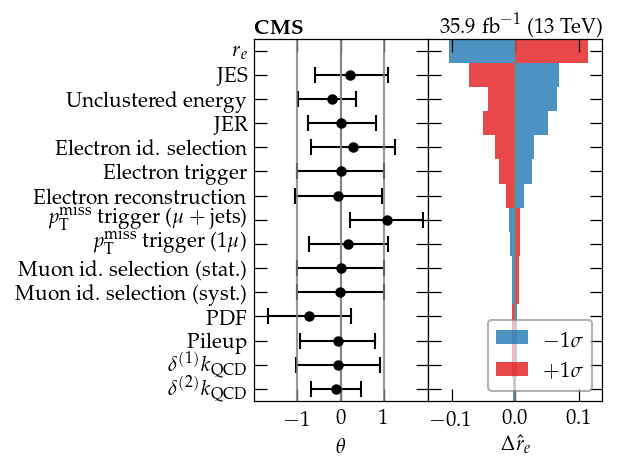

In [27]:
df = pd.DataFrame(results)
df["envelope"] = np.abs(df[["poi_paramup", "poi_paramdown"]]).max(axis=1)
df = df.sort_values("envelope").reset_index(drop=True).set_index(["param", "poi"])
selection = (
    df.index.get_level_values("param").isin([
        "rWJetsToENuNorm",
        "jesTotal", "unclust", "jerSF", "eleTrig", "eleIdIsoTight",
        "eleReco", "metTrigSingleMuonSyst", "metTrig1MuSyst",
        "d1kqcd", "muonIdTightStat", "d2kqcd", "pileup",
        "muonIdTightSyst", "dkmix", "lhePdfWeight", "d2keww",
        "d3kqcd", "btagSF", "lumi", "metTrigReferenceSyst", "muonIsoTightSyst",
        "d3keww", "tauIdVLoose", "eleIdIsoVeto",
    ])
)
tdf = df.loc[selection,:].drop("envelope", axis=1).iloc[-15:]
tdf.loc[("rWJetsToENuNorm", "rWJetsToENuNorm"),"param_value"] = np.nan
conv = dftools.draw.nuisance_names
conv["rWJetsToENuNorm"] = r'$r_e$'
fig, ax = dftools.draw.draw_impacts(
    tdf, converter=conv
)

ax[0].text(
    0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom',
    transform=ax[0].transAxes,
)
ax[1].text(
    1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom',
    transform=ax[1].transAxes,
)
ax[1].set_xlabel(r'$\Delta \hat{r}_e$')
ax[1].legend(loc=4, fancybox=True, edgecolor="gray")
fig.set_size_inches(3,3.2)
fig.align_labels(ax)
fig.savefig("plots/impacts_tfmu2ewj.pdf", format='pdf', bbox_inches='tight')

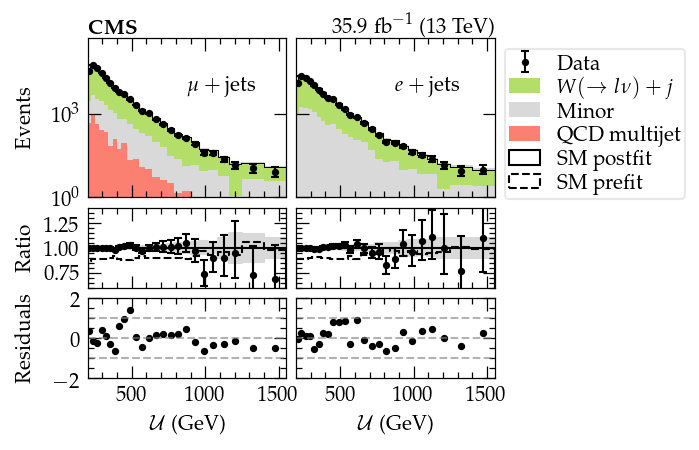

In [28]:
fig, ax = plt.subplots(
    figsize=(3.5, 3), dpi=150,
    nrows=3, ncols=2,
    sharex='col', sharey='row',
    gridspec_kw={
        "height_ratios": (2,1,1),
        "hspace": 0.1, "wspace": 0.05,
    },
)
ax[0,0].set_yscale('log')
ax[0,0].set_xlim(model.bins["SingleMuon"][0][0], model.bins["SingleMuon"][1][-1])
ax[0,1].set_xlim(model.bins["SingleMuon"][0][0], model.bins["SingleMuon"][1][-1])

model.draw_data("SingleMuon", ax[0,0], label="Data")
model.draw_prediction_total("SingleMuon", ax[0,0])
model.draw_prediction_procs("SingleMuon", ax[0,0])
model.draw_data("SingleMuon", ax[1,0], ratio=True)
model.draw_prediction_total("SingleMuon", ax[1,0], ratio=True, hkwargs={"label": "SM postfit"})
model.draw_prediction_total("SingleMuon", ax[1,0], ratio=True, prefit=True, band=False, hkwargs={"label": "SM prefit"})
model.draw_data("SingleMuon", ax[2,0], pull=True)

model.draw_data("SingleElectron", ax[0,1])
model.draw_prediction_total("SingleElectron", ax[0,1])
model.draw_prediction_procs("SingleElectron", ax[0,1])
model.draw_data("SingleElectron", ax[1,1], ratio=True)
model.draw_prediction_total("SingleElectron", ax[1,1], ratio=True)
model.draw_prediction_total("SingleElectron", ax[1,1], ratio=True, prefit=True, band=False)
model.draw_data("SingleElectron", ax[2,1], pull=True)

ax[0,0].set_ylim(1, 5e5)
ax[1,0].set_ylim(0.6, 1.4)
ax[2,0].set_ylim(-2, 2)

ax[0,1].set_ylim(1, 5e5)
ax[1,1].set_ylim(0.6, 1.4)
ax[2,1].set_ylim(-2, 2)

ax[2,0].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,0].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[2,1].axhline(0., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(1., lw=1, ls='--', color='gray', alpha=0.6)
ax[2,1].axhline(-1., lw=1, ls='--', color='gray', alpha=0.6)

ax[0,0].set_ylabel('Events')
ax[1,0].set_ylabel('Ratio')
ax[2,0].set_ylabel('Residuals')
ax[2,0].set_xlabel('$\mathcal{U}$ (GeV)')
ax[2,1].set_xlabel('$\mathcal{U}$ (GeV)')

h1, l1 = ax[0,0].get_legend_handles_labels()
h2, l2 = ax[1,0].get_legend_handles_labels()
ax[0,1].legend(
    h1[::-1]+h2, l1[::-1]+l2,
    loc=2, bbox_to_anchor=(1,1),
    fancybox=True, edgecolor="#d9d9d9",
    labelspacing=0.1, borderpad=0.2,
)

ax[0,0].text(0.5, 0.7, r'$\mu+\mathrm{jets}$', ha='left', va='center', transform=ax[0,0].transAxes)
ax[0,1].text(0.5, 0.7, r'$e+\mathrm{jets}$', ha='left', va='center', transform=ax[0,1].transAxes)

ax[0,0].text(0, 1, r'$\mathbf{CMS}$', ha='left', va='bottom', transform=ax[0,0].transAxes)
ax[0,1].text(1, 1, r'$35.9\ \mathrm{fb}^{-1}$ ($13\ \mathrm{TeV}$)', ha='right', va='bottom', transform=ax[0,1].transAxes)
fig.align_labels(ax)
fig.savefig("plots/postfit_tfmu2ewj.pdf", format="pdf", bbox_inches='tight')
pass

## View parameter effects

bin_min  bin_max
200.0    220.0      30007.664521
220.0    250.0      47652.736382
250.0    280.0      37267.529724
280.0    310.0      25408.995265
310.0    340.0      17313.991715
340.0    370.0      11626.744876
370.0    400.0       7976.328055
400.0    430.0       5180.575600
430.0    470.0       4481.997986
470.0    510.0       2782.512032
510.0    550.0       1804.622061
550.0    590.0       1222.623981
590.0    640.0        933.237634
640.0    690.0        565.579524
690.0    740.0        367.695084
740.0    790.0        232.767601
790.0    840.0        152.430574
840.0    900.0        115.089844
900.0    960.0         79.039728
960.0    1020.0        49.766794
1020.0   1090.0        41.491276
1090.0   1160.0        24.337940
1160.0   1250.0        13.788747
1250.0   1400.0        16.004099
1400.0   1550.0        11.335729
Name: prediction, dtype: float64


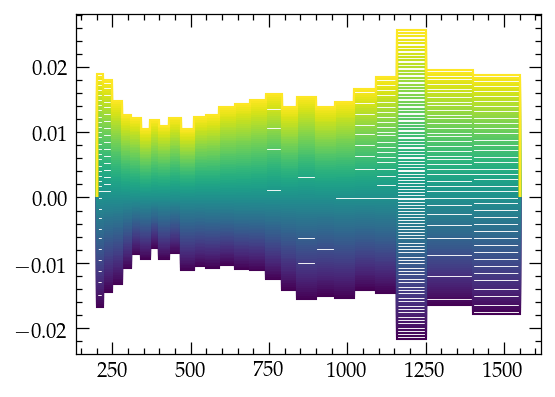

In [25]:
model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
parameters = model.parameters

region = "SingleMuon"
#proc = "WJetsToLnu"
nuis = "jesTotal"

nom = model.predictions(region)["prediction"]
print(nom)
binmin, binmax = model.bins[region]

fig, ax = plt.subplots()

ndiv = 100
cmap = plt.get_cmap('viridis', ndiv+1)

for idx, theta in enumerate(np.linspace(-1., 1., 101)):
    parameters[nuis] = theta
    model.set_parameters(parameters)
    vari = model.predictions(region)["prediction"]

    ax.hist(
        binmin, bins=list(binmin)+[binmax[-1]], weights=vari/nom-1,
        histtype='step', color=cmap(idx),
    )

/home/hep/sdb15/miniconda2/envs/zinv37/lib/python3.7/site-packages/pandas/core/indexing.py:1404: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


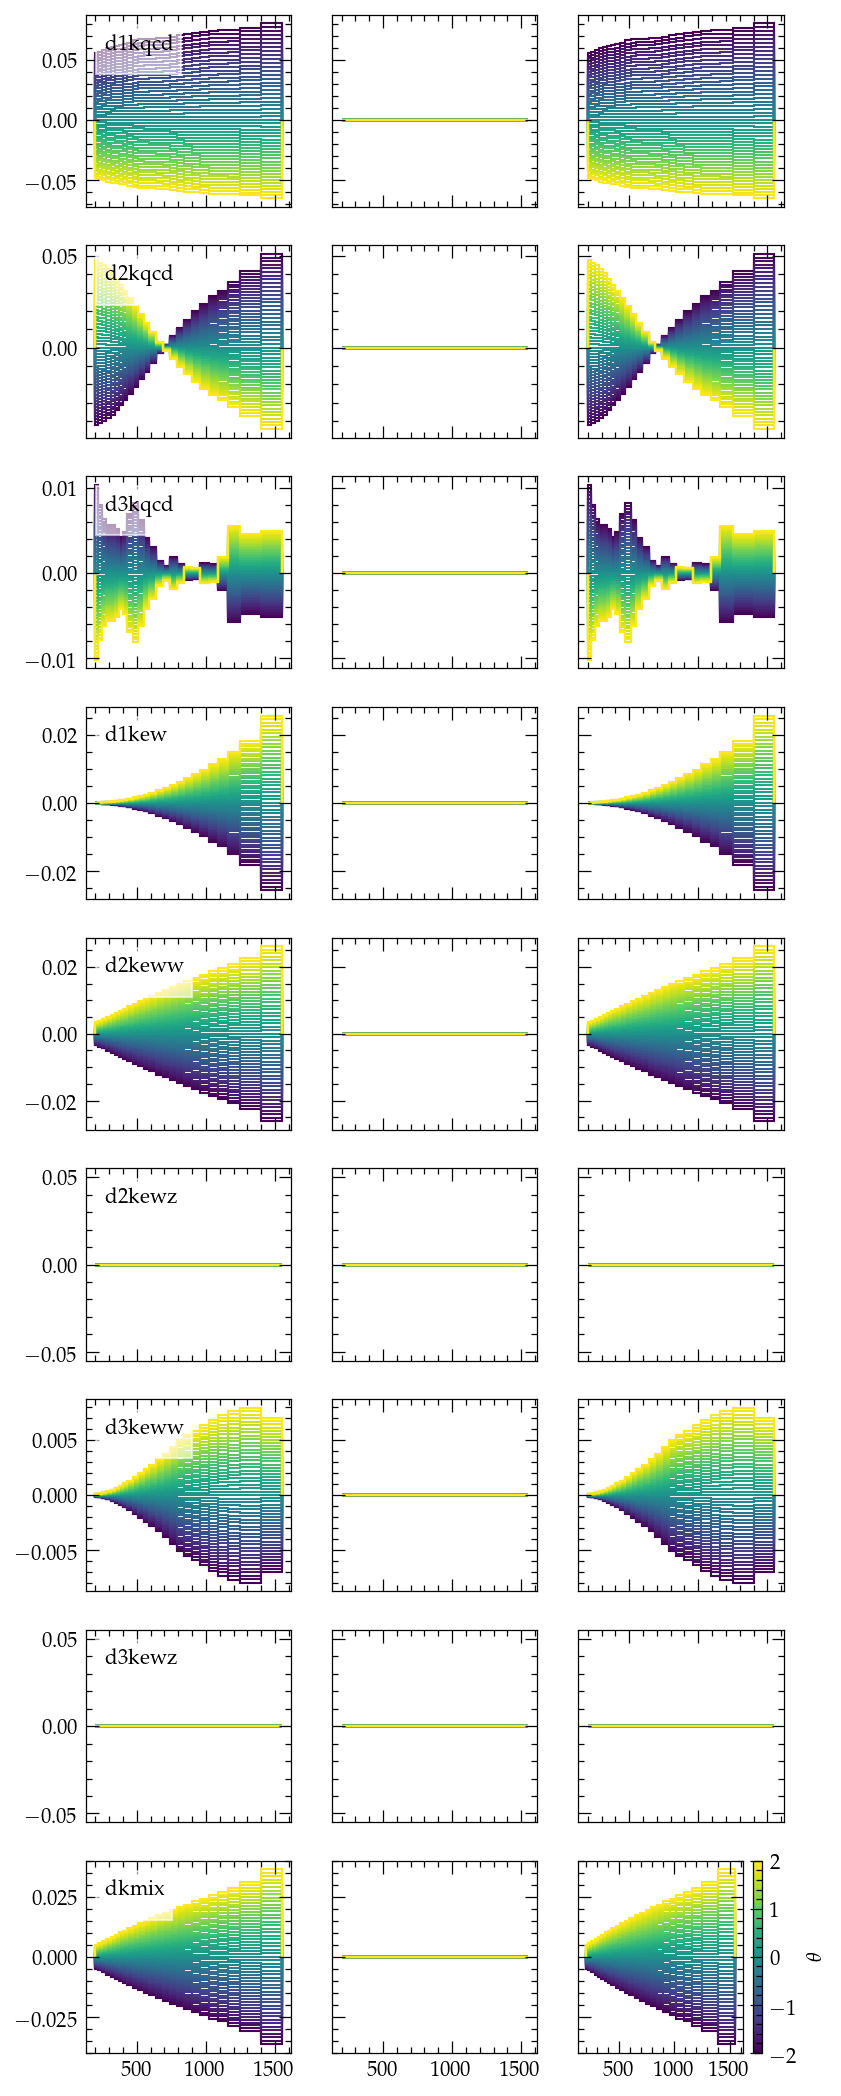

In [47]:
model = dftools.fitting.NLLModel2(df_data, df_mc, config, same_bin_widths=True)
parameters = copy.deepcopy(model.parameters)

bins = model.bins["SingleMuon"]
process = "WJetsToLNu"
pred_nom_m = model.prediction("SingleMuon").loc[(process)].values
pred_nom_e = model.prediction("SingleElectron").loc[(process)].values

ndiv = 50
cmap = plt.get_cmap('viridis', ndiv+1)

nuisances = ["d1kqcd", "d2kqcd", "d3kqcd", "d1kew", "d2keww", "d2kewz", "d3keww", "d3kewz", "dkmix"]
fig, ax = plt.subplots(
    figsize=(6, 2*len(nuisances)), dpi=150,
    nrows=len(nuisances), ncols=3,
    sharex=True, sharey='row',
)
    
for nidx, nuis in enumerate(nuisances):
    for idx, theta in enumerate(np.linspace(-1., 1., ndiv+1)):
        tparams = copy.deepcopy(parameters)
        tparams[nuis] = theta
        model.set_parameters(tparams)
        pred_m = model.prediction("SingleMuon").loc[(process)].values
        pred_e = model.prediction("SingleElectron").loc[(process)].values
        
        if len(nuisances)>1:
            row = nidx
            tax = ax[row,0]
        else:
            tax = ax[0]
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred_m/pred_nom_m-1.,
            histtype='step',
            color=cmap(idx),
        )
        tax.legend([], [], loc=2, title=nuis)
        
        if len(nuisances)>1:
            tax = ax[row,1]
        else:
            tax = ax[1]
            
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=pred_e/pred_nom_e-1.,
            histtype='step',
            color=cmap(idx),
        )
        
        if len(nuisances)>1:
            tax = ax[row,2]
        else:
            tax = ax[2]
        tax.hist(
            bins[0],
            bins=list(bins[0])+[bins[1][-1]],
            weights=((pred_m/pred_nom_m)/(pred_e/pred_nom_e))-1.,
            histtype='step',
            color=cmap(idx),
        )
        
        ylim = max(np.abs(tax.get_ylim()))
        if ylim < 1e-5:
            tax.set_ylim(-1e-3, 1e-3)
    
import matplotlib as mpl
norm = mpl.colors.Normalize(vmin=-2., vmax=2.)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm)
cbar.set_label(r'$\theta$')

KeyError: 'rWJets'

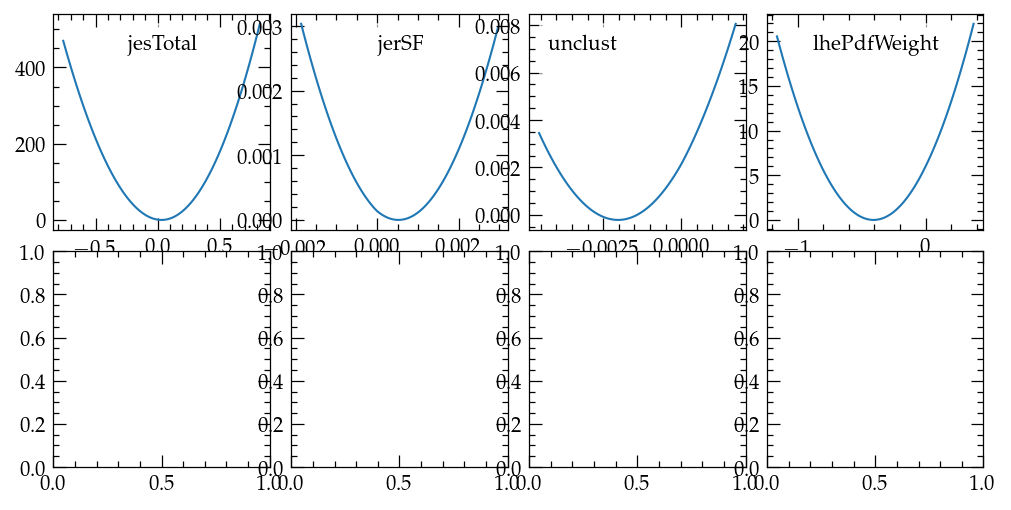

In [100]:
parameters = [
    "jesTotal", "jerSF", "unclust", "lhePdfWeight",
    "rWJets", "rWJetsToENuNorm", "rWJetsToENuShape",
]
nrows = (len(parameters)-1)//4 + 1

fix, ax = plt.subplots(
    figsize=(8, 2*nrows), dpi=150,
    nrows=nrows, ncols=4,
    sharex=False, sharey=False,
    gridspec_kw={"hspace": 0.1, "wspace": 0.1},
)

pvals = dict(minimizer.values)
fval = minimizer.fval

for idx, param in enumerate(parameters):
    x, y = minimizer.profile(param, subtract_min=True)
    
    #bf_vals = results.set_index(["param"]).loc[param]
    #x = []
    #y = []
    #for theta in np.linspace(-2., 2., 21):
    #    _pvals = copy.deepcopy(pvals)
    #    _x = bf_vals["param_value"] + theta*((theta<0.)*np.abs(bf_vals["param_merrdown"]) + (theta>=0.)*bf_vals["param_merrup"])
    #    _pvals[param] = _x
    #    model.set_parameters(_pvals)
    #    x.append(_x)
    #    y.append(model.nll()-fval)
    
    row = idx//4
    col = idx%4
    ax[row,col].plot(x, y)
    ax[row,col].legend([], [], title=param)

In [28]:
parameters = copy.deepcopy(model.parameters)

def scan(x, y, p1, p2):
    tp = copy.deepcopy(parameters)
    tp[p1] = x
    tp[p2] = y
    return model(tp)

xs = np.linspace(0.5, 1.5, 21)
ys = np.linspace(-3., 3., 21)

X, Y = np.meshgrid(xs, ys)
Z = np.zeros_like(X)
for ix in range(xs.shape[0]):
    for iy in range(ys.shape[0]):
        Z[ix,iy] = scan(X[ix,iy], Y[ix,iy], "rWJetsToENuNorm", "metTrigSingleMuonSyst")

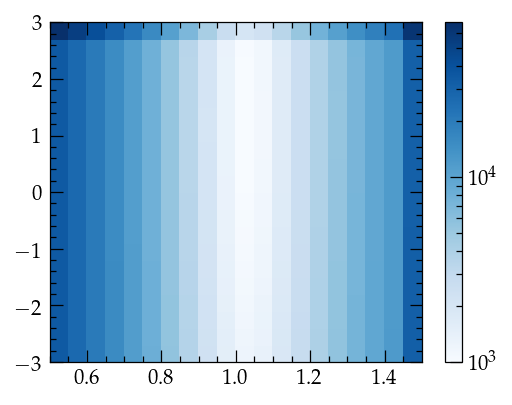

In [29]:
import matplotlib as mpl

fig, ax = plt.subplots()
h = ax.hist2d(
    X.ravel(), Y.ravel(),
    bins=(xs, ys),
    weights=Z.ravel(),
    norm=mpl.colors.LogNorm(),
    cmap="Blues",
)
cbar = fig.colorbar(h[3], ax=ax)
pass